In [14]:
from transformers import WhisperForConditionalGeneration
from transformers import WhisperProcessor
from transformers import AutoTokenizer, pipeline


tokenizer = AutoTokenizer.from_pretrained("distil-whisper/distil-small.en")

processor = WhisperProcessor.from_pretrained(
    "distil-whisper/distil-small.en"
)


model = WhisperForConditionalGeneration.from_pretrained("distil-whisper/distil-small.en")

In [15]:
from functools import partial

# disable cache during training since it's incompatible with gradient checkpointing
model.config.use_cache = False

# set language and task for generation and re-enable cache
model.generate = partial(
    model.generate, forced_decoder_ids=None, use_cache=True
)

In [8]:
from datasets import load_dataset, DatasetDict

dataset = load_dataset("averageandyyy/part_1_imda_10000")
# train_test_dataset = dataset["train"].train_test_split(test_size=0.2, seed=42)  # 80% train, 20% test/val
# train_dataset = train_test_dataset['train']
# test_val_dataset = train_test_dataset['test'].train_test_split(test_size=0.5, seed=42)  # Split remaining 20% into 10% test and 10% val
# dataset = DatasetDict({
#     'train': train_dataset,
#     'test': test_val_dataset['train'],
#     'validation': test_val_dataset['test']
# })


In [9]:
dataset

DatasetDict({
    train: Dataset({
        features: ['transcript', 'path', 'waveform'],
        num_rows: 10000
    })
})


Train Transcript Length Statistics:
count    8000.000000
mean       66.593125
std        26.353551
min         9.000000
25%        46.000000
50%        63.000000
75%        85.000000
max       155.000000
dtype: float64


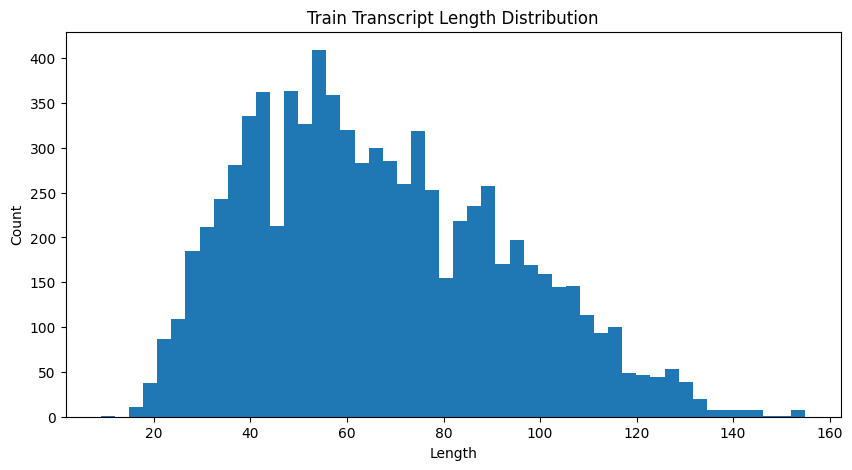


Train Word Count Statistics:
count    8000.000000
mean       12.098500
std         4.343173
min         2.000000
25%         9.000000
50%        12.000000
75%        15.000000
max        30.000000
dtype: float64


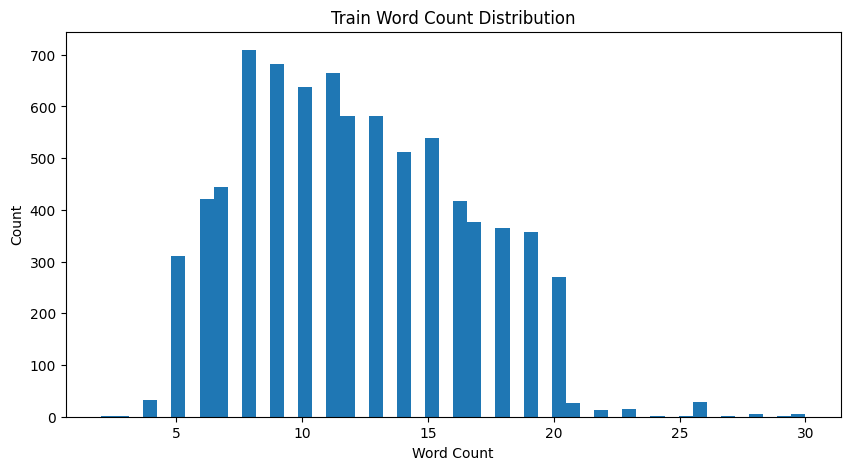


Test Transcript Length Statistics:
count    1000.000000
mean       68.442000
std        26.409887
min        16.000000
25%        49.000000
50%        65.000000
75%        88.000000
max       155.000000
dtype: float64


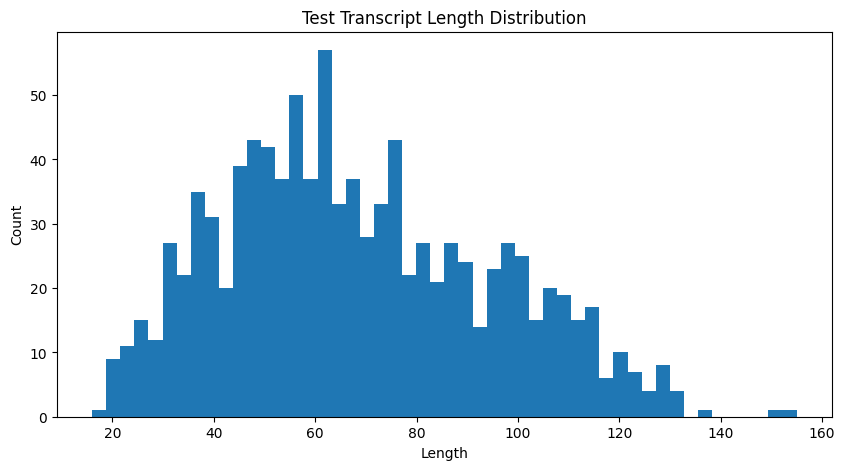


Test Word Count Statistics:
count    1000.000000
mean       12.307000
std         4.318032
min         4.000000
25%         9.000000
50%        12.000000
75%        15.000000
max        30.000000
dtype: float64


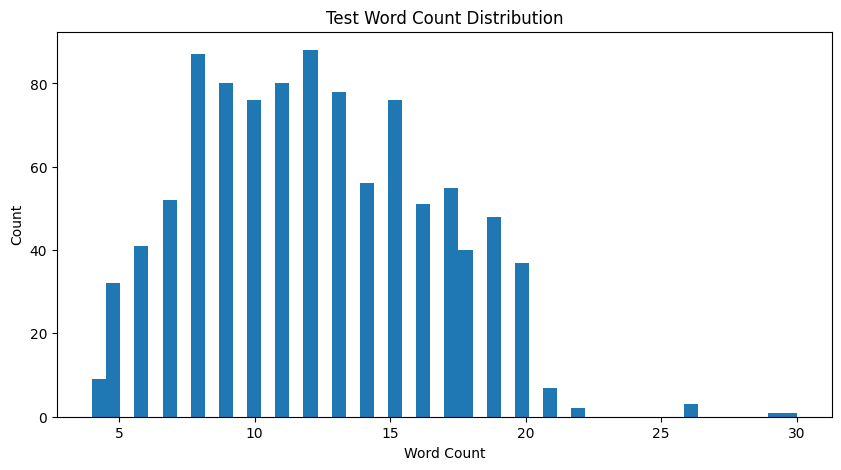


Validation Transcript Length Statistics:
count    1000.000000
mean       69.106000
std        26.928756
min        16.000000
25%        48.000000
50%        67.000000
75%        89.000000
max       155.000000
dtype: float64


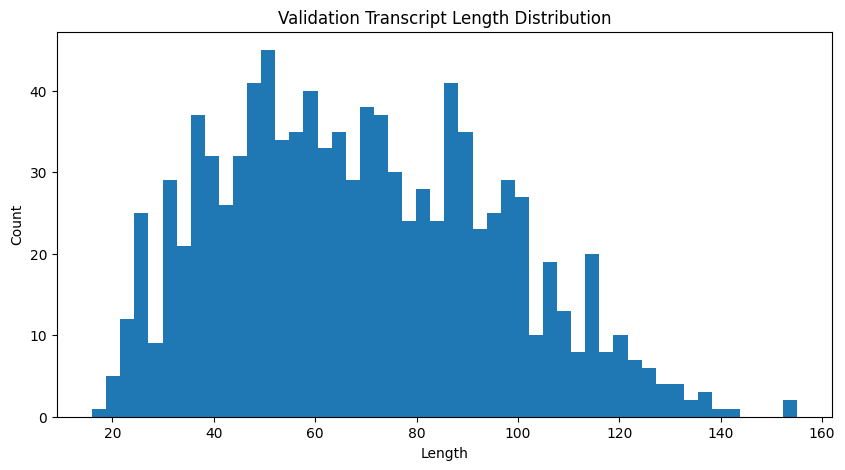


Validation Word Count Statistics:
count    1000.000000
mean       12.457000
std         4.421957
min         4.000000
25%         9.000000
50%        12.000000
75%        16.000000
max        30.000000
dtype: float64


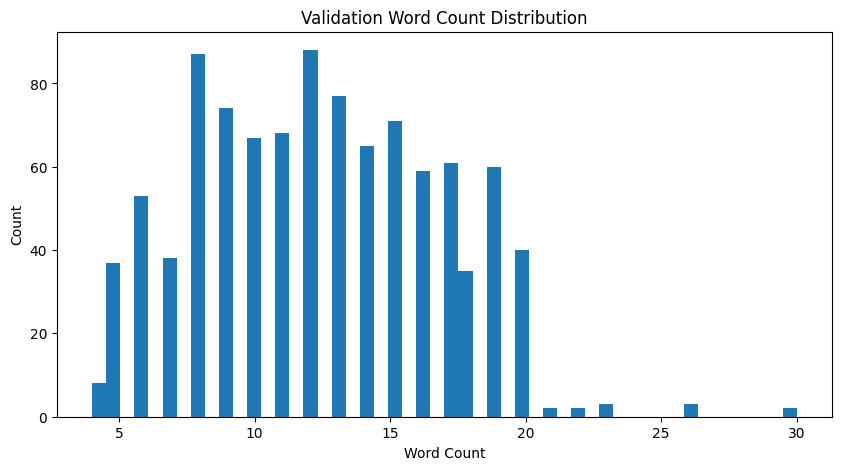

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def analyze_transcripts(split):
    transcripts = [sample['transcript'] for sample in dataset[split]]

    # Length statistics
    lengths = [len(t) for t in transcripts]
    print(f"\n{split.capitalize()} Transcript Length Statistics:")
    print(pd.Series(lengths).describe())

    # Plot length distribution
    plt.figure(figsize=(10, 5))
    plt.hist(lengths, bins=50)
    plt.title(f"{split.capitalize()} Transcript Length Distribution")
    plt.xlabel("Length")
    plt.ylabel("Count")
    plt.show()

    # Word count statistics
    word_counts = [len(t.split()) for t in transcripts]
    print(f"\n{split.capitalize()} Word Count Statistics: ")
    print(pd.Series(word_counts).describe())

    # Plot word count distribution
    plt.figure(figsize=(10, 5))
    plt.hist(word_counts, bins=50)
    plt.title(f"{split.capitalize()} Word Count Distribution")
    plt.xlabel("Word Count")
    plt.ylabel("Count")
    plt.show()

for split in dataset:
    analyze_transcripts(split)


Train Audio Duration Statistics (seconds):
count    8000.000000
mean        5.213080
std         1.831607
min         1.675000
25%         3.800000
50%         4.880000
75%         6.310000
max        26.660000
dtype: float64


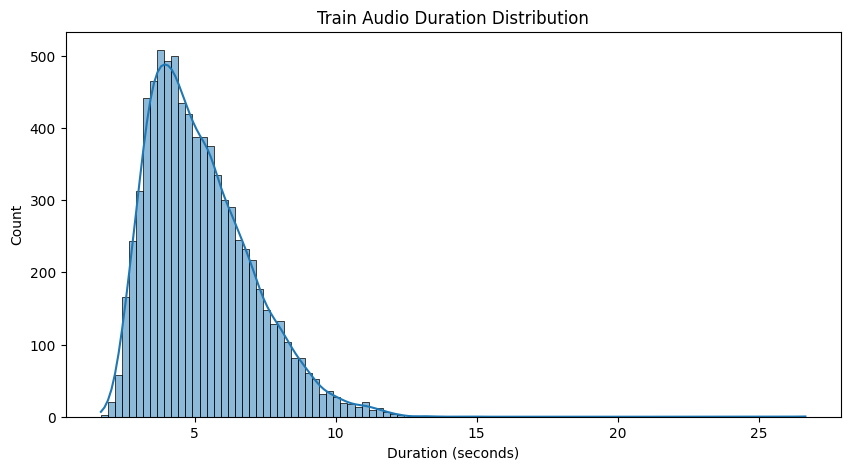

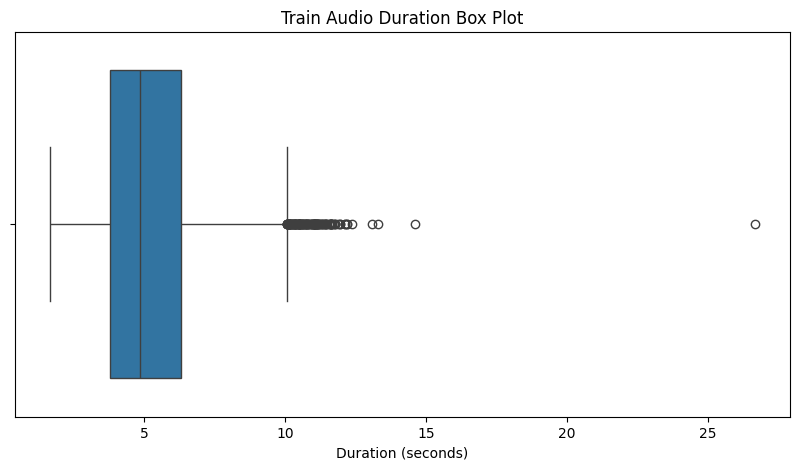


Test Audio Duration Statistics (seconds):
count    1000.000000
mean        5.295431
std         1.807005
min         1.936000
25%         3.957500
50%         5.046000
75%         6.390000
max        12.982000
dtype: float64


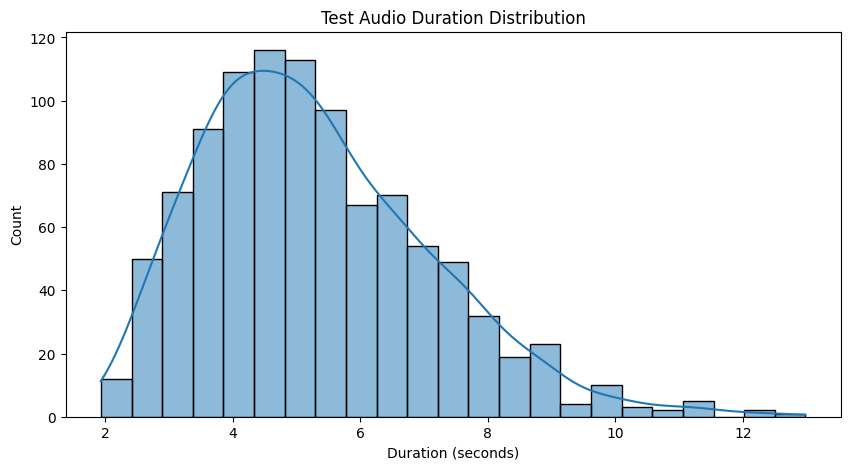

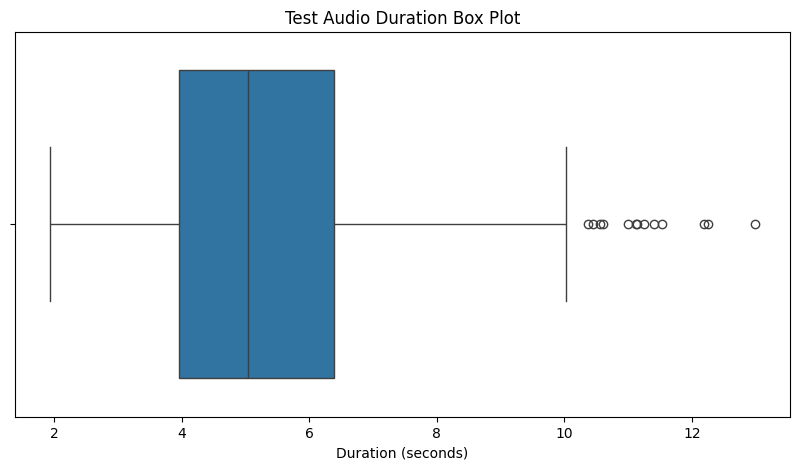


Validation Audio Duration Statistics (seconds):
count    1000.000000
mean        5.332828
std         1.851193
min         1.996687
25%         3.910000
50%         5.022000
75%         6.490000
max        13.923000
dtype: float64


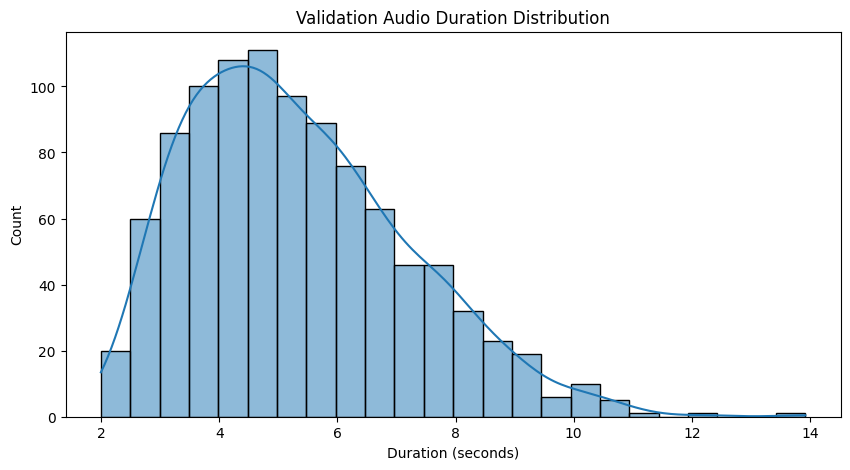

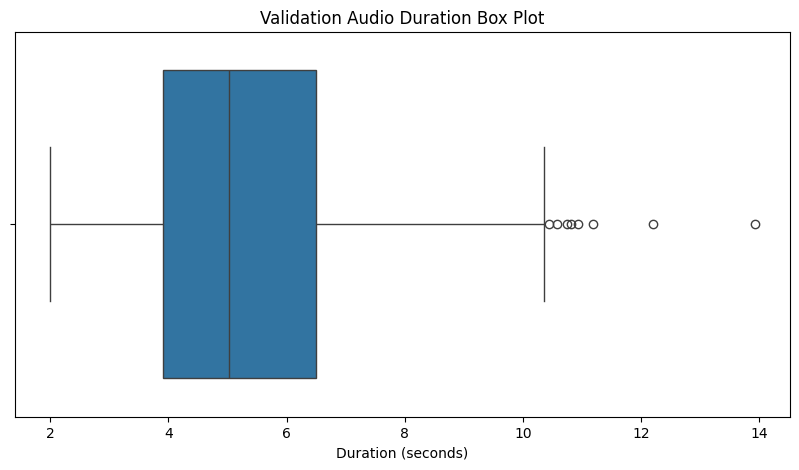

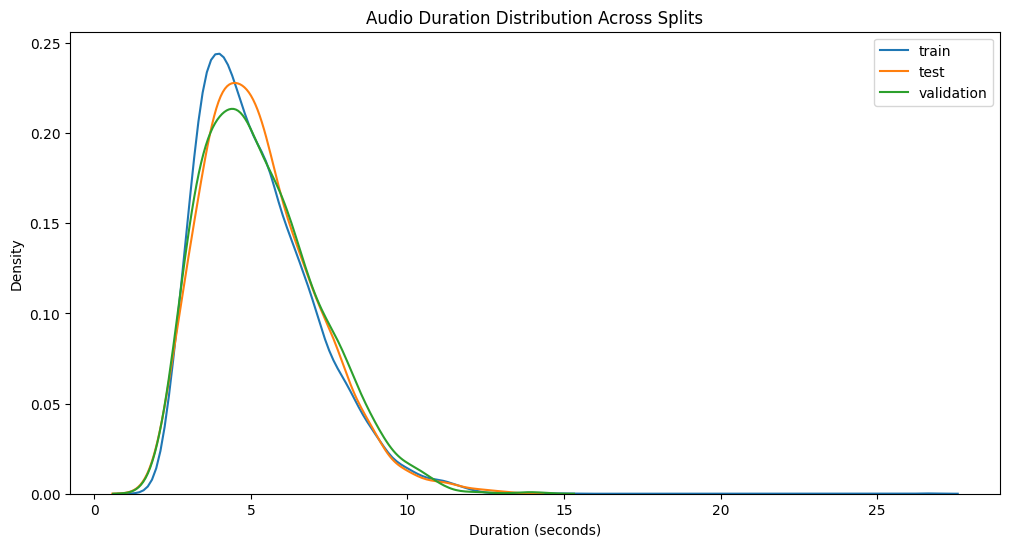


Overall Audio Duration Statistics (seconds):
count    10000.000000
mean         5.233290
std          1.831415
min          1.675000
25%          3.830000
50%          4.920000
75%          6.330000
max         26.660000
dtype: float64

Potential outliers: durations < 0.08s or > 10.08s
Number of potential outliers: 147


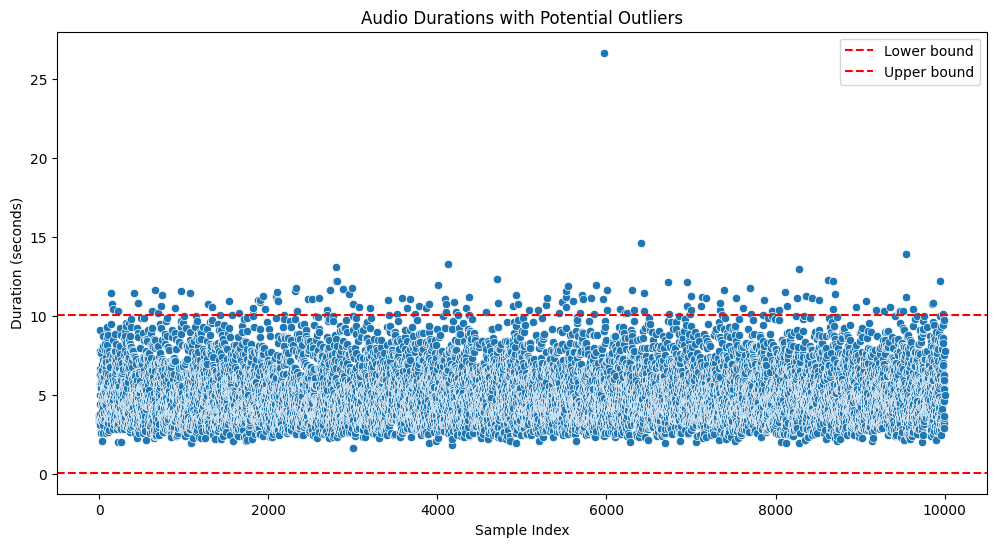

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_audio_durations(dataset):
    durations = {}

    for split in dataset:
        durations[split] = []
        for sample in dataset[split]:
            # Calculate duration in seconds
            duration = len(sample['waveform']) / 16000  # 16000 Hz sampling rate
            durations[split].append(duration)

    return durations

# Calculate durations for all splits
all_durations = analyze_audio_durations(dataset)

# Analyze durations
for split, durations in all_durations.items():
    print(f"\n{split.capitalize()} Audio Duration Statistics (seconds):")
    duration_series = pd.Series(durations)
    print(duration_series.describe())

    # Plot histogram
    plt.figure(figsize=(10, 5))
    sns.histplot(durations, kde=True)
    plt.title(f"{split.capitalize()} Audio Duration Distribution")
    plt.xlabel("Duration (seconds)")
    plt.ylabel("Count")
    plt.show()

    # Plot box plot
    plt.figure(figsize=(10, 5))
    sns.boxplot(x=durations)
    plt.title(f"{split.capitalize()} Audio Duration Box Plot")
    plt.xlabel("Duration (seconds)")
    plt.show()

# Compare durations across splits
plt.figure(figsize=(12, 6))
for split, durations in all_durations.items():
    sns.kdeplot(durations, label=split)
plt.title("Audio Duration Distribution Across Splits")
plt.xlabel("Duration (seconds)")
plt.ylabel("Density")
plt.legend()
plt.show()

# Calculate overall statistics
all_durations_combined = [d for durations in all_durations.values() for d in durations]
print("\nOverall Audio Duration Statistics (seconds):")
overall_duration_series = pd.Series(all_durations_combined)
print(overall_duration_series.describe())

# Identify potential outliers
q1 = overall_duration_series.quantile(0.25)
q3 = overall_duration_series.quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - (1.5 * iqr)
upper_bound = q3 + (1.5 * iqr)

print(f"\nPotential outliers: durations < {lower_bound:.2f}s or > {upper_bound:.2f}s")
outliers = overall_duration_series[(overall_duration_series < lower_bound) | (overall_duration_series > upper_bound)]
print(f"Number of potential outliers: {len(outliers)}")

# Plot potential outliers
plt.figure(figsize=(12, 6))
sns.scatterplot(x=range(len(overall_duration_series)), y=overall_duration_series)
plt.axhline(y=lower_bound, color='r', linestyle='--', label='Lower bound')
plt.axhline(y=upper_bound, color='r', linestyle='--', label='Upper bound')
plt.title("Audio Durations with Potential Outliers")
plt.xlabel("Sample Index")
plt.ylabel("Duration (seconds)")
plt.legend()
plt.show()

In [16]:
dataset['train'][0]

{'transcript': 'FIND OUT MORE ABOUT THIS BAKERY BELOW',
 'path': '202811626.WAV',
 'waveform': [0.00030517578125,
  0.00030517578125,
  0.001007080078125,
  0.000640869140625,
  0.000640869140625,
  0.0013427734375,
  0.001007080078125,
  0.0013427734375,
  0.001007080078125,
  0.001007080078125,
  0.0013427734375,
  0.001708984375,
  0.001708984375,
  0.002044677734375,
  0.002044677734375,
  0.002044677734375,
  0.002410888671875,
  0.002410888671875,
  0.00274658203125,
  0.00311279296875,
  0.003448486328125,
  0.003448486328125,
  0.003814697265625,
  0.003814697265625,
  0.003448486328125,
  0.003448486328125,
  0.003448486328125,
  0.00311279296875,
  0.003448486328125,
  0.00311279296875,
  0.00274658203125,
  0.002410888671875,
  0.002410888671875,
  0.0013427734375,
  0.001708984375,
  0.001708984375,
  0.001708984375,
  0.002044677734375,
  0.001708984375,
  0.001708984375,
  0.0013427734375,
  0.0013427734375,
  0.001007080078125,
  0.000640869140625,
  0.000640869140625,
 

In [20]:
import numpy as np
import soundfile as sf
import IPython.display as ipd

# Convert waveform to numpy array and save as audio file
waveform = np.array(dataset['train'][0]['waveform'])
sf.write('audio.wav', waveform, 16000)

# Play the audio file
ipd.Audio('audio.wav')


In [18]:
def prepare_dataset(example):
    audio = example

    example = processor(
        audio=audio["waveform"],
        sampling_rate=16000,
        text=example["transcript"],
    )

    # compute input length of audio sample in seconds
    example["input_length"] = len(audio["waveform"]) / 16000

    return example

In [19]:
import torch

# Move the dataset to GPU if available
# device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Update the prepare_dataset function to utilize GPU
def prepare_dataset(example):
    audio = example

    example = processor(
        audio=audio["waveform"],
        sampling_rate=16000,
        text=example["transcript"],
    )

    # compute input length of audio sample in seconds
    example["input_length"] = len(audio["waveform"]) / 16000

    # Move input features to GPU
    # example["input_features"] = example["input_features"].to(device)
    example["input_features"] = example["input_features"]

    return example

dataset = dataset.map(
    prepare_dataset, remove_columns=dataset.column_names["train"], num_proc=1
)

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [20]:
dataset

DatasetDict({
    train: Dataset({
        features: ['input_features', 'labels', 'input_length'],
        num_rows: 8000
    })
    test: Dataset({
        features: ['input_features', 'labels', 'input_length'],
        num_rows: 1000
    })
    validation: Dataset({
        features: ['input_features', 'labels', 'input_length'],
        num_rows: 1000
    })
})

In [21]:
max_input_length = 30.0


def is_audio_in_length_range(length):
    return length < max_input_length

dataset = dataset.filter(is_audio_in_length_range, input_columns=["input_length"])
dataset

Filter:   0%|          | 0/8000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_features', 'labels', 'input_length'],
        num_rows: 8000
    })
    test: Dataset({
        features: ['input_features', 'labels', 'input_length'],
        num_rows: 1000
    })
    validation: Dataset({
        features: ['input_features', 'labels', 'input_length'],
        num_rows: 1000
    })
})

In [22]:
import torch

from dataclasses import dataclass
from typing import Any, Dict, List, Union



class DataCollatorSpeechSeq2SeqWithPadding:
    def __init__(self, processor):
        self.processor = processor

    def __call__(
        self, features: List[Dict[str, Union[List[int], torch.Tensor]]]
    ) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lengths and need different padding methods
        # first treat the audio inputs by simply returning torch tensors
        input_features = [
            {"input_features": feature["input_features"][0]} for feature in features
        ]
        batch = self.processor.feature_extractor.pad(input_features, return_tensors="pt")

        # get the tokenized label sequences
        label_features = [{"input_ids": feature["labels"]} for feature in features]
        # pad the labels to max length
        labels_batch = self.processor.tokenizer.pad(label_features, return_tensors="pt")

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(
            labels_batch.attention_mask.ne(1), -100
        )

        # if bos token is appended in previous tokenization step,
        # cut bos token here as it's append later anyways
        if (labels[:, 0] == self.processor.tokenizer.bos_token_id).all().cpu().item():
            labels = labels[:, 1:]

        batch["labels"] = labels

        return batch

data_collator = DataCollatorSpeechSeq2SeqWithPadding(processor=processor)

In [23]:
import evaluate
from transformers.models.whisper.english_normalizer import BasicTextNormalizer

normalizer = BasicTextNormalizer()


metric = evaluate.load("wer")

def compute_metrics(pred):
    pred_ids = pred.predictions
    label_ids = pred.label_ids

    # replace -100 with the pad_token_id
    label_ids[label_ids == -100] = processor.tokenizer.pad_token_id

    # we do not want to group tokens when computing the metrics
    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    label_str = processor.batch_decode(label_ids, skip_special_tokens=True)

    # compute orthographic wer
    wer_ortho = 100 * metric.compute(predictions=pred_str, references=label_str)

    # compute normalised WER
    pred_str_norm = [normalizer(pred) for pred in pred_str]
    label_str_norm = [normalizer(label) for label in label_str]
    # filtering step to only evaluate the samples that correspond to non-zero references:
    pred_str_norm = [
        pred_str_norm[i] for i in range(len(pred_str_norm)) if len(label_str_norm[i]) > 0
    ]
    label_str_norm = [
        label_str_norm[i]
        for i in range(len(label_str_norm))
        if len(label_str_norm[i]) > 0
    ]

    wer = 100 * metric.compute(predictions=pred_str_norm, references=label_str_norm)

    return {"wer_ortho": wer_ortho, "wer": wer}

In [24]:
from transformers import Seq2SeqTrainingArguments, GenerationConfig

# generation_config = GenerationConfig.from_pretrained("distil-whisper/distil-small.en")

training_args = Seq2SeqTrainingArguments(
    output_dir="./models/whisper-small-distileld-singlish",
    per_device_train_batch_size=128,
    gradient_accumulation_steps=1,
    learning_rate=1e-5,
    # warmup_steps=500,
    warmup_steps=20,
    # max_steps=5000,
    max_steps=125,
    gradient_checkpointing=True,
    fp16=False,
    evaluation_strategy="steps",
    per_device_eval_batch_size=16,
    predict_with_generate=True,
    generation_max_length=225,
    save_steps=25,
    # eval_steps=500,
    eval_steps=25,
    # logging_steps=500,
    logging_steps=2,
    report_to=["wandb"],
    load_best_model_at_end=False,
    metric_for_best_model="wer",
    greater_is_better=False,
    push_to_hub=False,
    max_grad_norm=1.0,
)

/Users/jon/code/aisg/deep-skilling-phase/pytorch-lightning-tutorial/.venv/lib/python3.11/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [25]:
import os
os.environ["WANDB_PROJECT"] = "whisper-finetune"

In [ ]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=processor.feature_extractor,
)

trainer.train()

In [2]:
import pandas as pd
df = pd.read_parquet('./data/data.parquet')
df.head()

,audio,transcript
0,{'bytes': b'RIFFd\x9a\x02\x00WAVEfmt \x10\x00\...,SHE WON A CAR BECAUSE SHE WAS THE TWELFTH PERS...
1,{'bytes': b'RIFFd\xe0\x02\x00WAVEfmt \x10\x00\...,AS THEY WALKED BACK THEY WERE SHOCKED TO SEE A...
2,{'bytes': b'RIFFd\xdc\x01\x00WAVEfmt \x10\x00\...,HEAVY RAINS CAUSED A FLOOD IN THE VILLAGE
3,{'bytes': b'RIFF\xa4B\x01\x00WAVEfmt \x10\x00\...,HE GULPED DOWN HIS BEER
4,{'bytes': b'RIFF\x04\xda\x01\x00WAVEfmt \x10\x...,SOME PEOPLE GO TO COURT TO FIGHT FOR THEIR PRI...


In [3]:
df['audio'][0]

{'bytes': b'RIFFd\x9a\x02\x00WAVEfmt \x10\x00\x00\x00\x01\x00\x01\x00\x80>\x00\x00\x00}\x00\x00\x02\x00\x10\x00data@\x9a\x02\x00\xf6\xff\xe9\xff\xe9\xff\xe8\xff\xe0\xff\xde\xff\xdc\xff\xd6\xff\xd0\xff\xcd\xff\xc8\xff\xc3\xff\xc4\xff\xc4\xff\xc5\xff\xc7\xff\xce\xff\xd0\xff\xd2\xff\xd8\xff\xdb\xff\xe1\xff\xe9\xff\xee\xff\xf1\xff\xf3\xff\xf4\xff\xf3\xff\xf0\xff\xeb\xff\xe9\xff\xe4\xff\xe4\xff\xdd\xff\xd9\xff\xd7\xff\xd2\xff\xcb\xff\xc7\xff\xca\xff\xcd\xff\xd1\xff\xd7\xff\xda\xff\xdb\xff\xe2\xff\xe8\xff\xeb\xff\xf1\xff\xf7\xff\xf3\xff\xf1\xff\xf3\xff\xf3\xff\xee\xff\xec\xff\xeb\xff\xe3\xff\xe4\xff\xdf\xff\xd7\xff\xd5\xff\xda\xff\xd8\xff\xdb\xff\xe5\xff\xe4\xff\xe5\xff\xea\xff\xed\xff\xed\xff\xef\xff\xf5\xff\xfa\xff\xff\xff\xfe\xff\xf9\xff\xf6\xff\xf2\xff\xf4\xff\xee\xff\xe9\xff\xea\xff\xe7\xff\xe4\xff\xe1\xff\xe0\xff\xe2\xff\xe3\xff\xe3\xff\xe2\xff\xe8\xff\xec\xff\xe8\xff\xee\xff\xf3\xff\xfb\xff\xfc\xff\xfd\xff\xfd\xff\xfb\xff\xfb\xff\xf7\xff\xf5\xff\xf3\xff\xf1\xff\xf1\xff\xee\xff\xe9\xff

In [5]:
import numpy as np
import IPython.display as ipd

# Extract the audio bytes and convert them to a NumPy array
audio_bytes = df['audio'][1]['bytes']
audio_array = np.frombuffer(audio_bytes, dtype=np.int16)  # Assuming the audio is in 16-bit PCM format

# Play the audio
ipd.Audio(audio_array, rate=16000)  # Set the sample rate to 16 kHz